# Credit Card Fraud Detection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve,precision_recall_curve,auc
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
df=pd.read_csv(r"C:\Users\DELL\Desktop\creditcard.csv")
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [4]:
print(df['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


In [5]:
X=df.drop('Class', axis=1)
y=df['Class']
scaler=StandardScaler()
X[['Amount','Time']]=scaler.fit_transform(X[['Amount','Time']])
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3,random_state=42, stratify=y)
sm=SMOTE(random_state=42)
X_res,y_res=sm.fit_resample(X_train,y_train)
print("Before SMOTE:",y_train.value_counts())
print("After SMOTE:",y_res.value_counts())

Before SMOTE: Class
0    199020
1       344
Name: count, dtype: int64
After SMOTE: Class
0    199020
1    199020
Name: count, dtype: int64


In [6]:
model=LogisticRegression(max_iter=1000,class_weight='balanced')
model.fit(X_res,y_res)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [7]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
    print("="*60)
evaluate_model(model, X_test, y_test)

Confusion Matrix:
 [[83376  1919]
 [   18   130]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443

ROC-AUC Score: 0.9659891030018235


In [8]:
rf=RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_res,y_res)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [9]:
evaluate_model(rf,X_test,y_test)

Confusion Matrix:
 [[85276    19]
 [   31   117]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.79      0.82       148

    accuracy                           1.00     85443
   macro avg       0.93      0.90      0.91     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9605951839640803


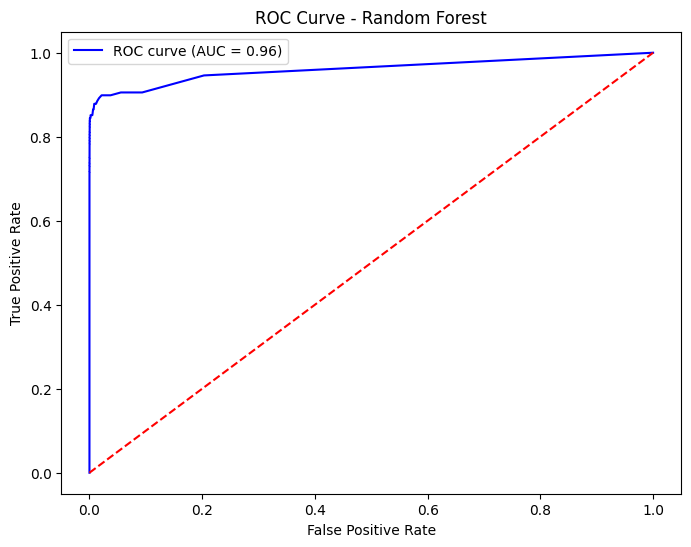

In [10]:
y_pred_proba=rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

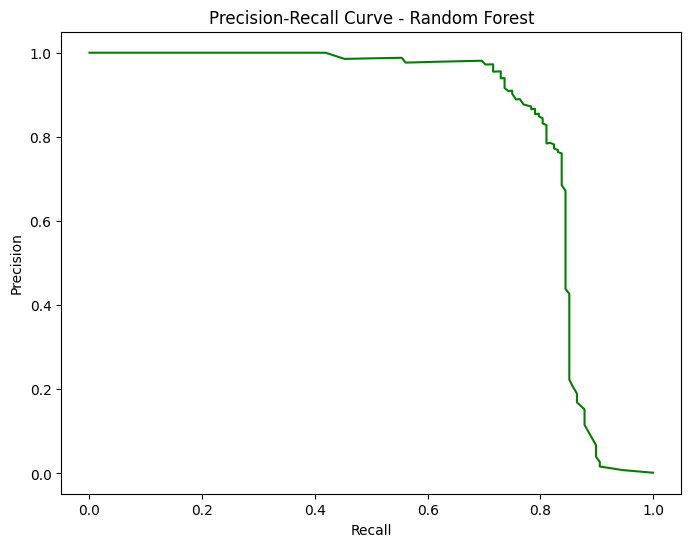

In [11]:
prec, rec, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(rec, prec, color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.show()

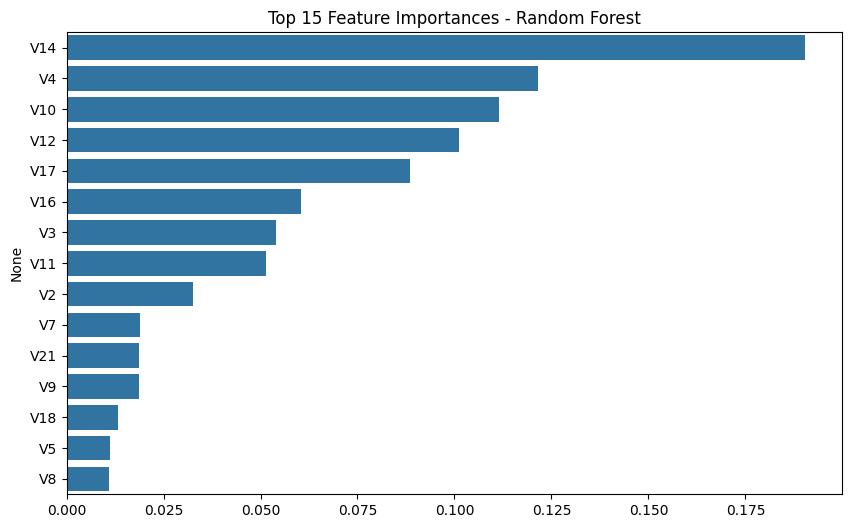

In [12]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices][:15], y=X.columns[indices][:15])
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

In [13]:
def summarize_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    roc_auc = roc_auc_score(y_test, y_proba)
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(rec, prec)

    print(f"===== {model_name} =====")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"PR-AUC Score : {pr_auc:.4f}")
    print("="*60)

    return {
        "Model": model_name,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    }

# Example usage:
results = []
results.append(summarize_model(LogisticRegression(max_iter=1000, class_weight="balanced"), X_res, y_res, X_test, y_test, "Logistic Regression"))
results.append(summarize_model(RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42), X_res, y_res, X_test, y_test, "Random Forest"))

# Convert results into a DataFrame for quick comparison
summary_df = pd.DataFrame(results)
print("\nModel Comparison:\n", summary_df)

===== Logistic Regression =====
Confusion Matrix:
 [[83376  1919]
 [   18   130]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.9775    0.9885     85295
           1     0.0634    0.8784    0.1183       148

    accuracy                         0.9773     85443
   macro avg     0.5316    0.9279    0.5534     85443
weighted avg     0.9982    0.9773    0.9870     85443

ROC-AUC Score: 0.9660
PR-AUC Score : 0.7428
===== Random Forest =====
Confusion Matrix:
 [[85276    19]
 [   31   117]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     85295
           1     0.8603    0.7905    0.8239       148

    accuracy                         0.9994     85443
   macro avg     0.9300    0.8952    0.9118     85443
weighted avg     0.9994    0.9994    0.9994     85443

ROC-AUC Score: 0.9606
PR-AUC Score : 0.8317

Model Comparison:
                  Model   ROC-A